In [1]:
%store -r after_scaler
%store -r out

In [108]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras import layers, Sequential
from tensorflow import feature_column

In [3]:
df = out.copy()
df.rename(columns = {'Gender':'gender',	
                     'Age':'age', 
                     'Birth Weight':'birth_weight',
                     'Birth Length' : 'birth_length', 
                     'Body Weight' : 'body_weight', 
                     'Body Length' : 'body_length', 
                     'Breastfeeding':'breastfeeding'},
                     inplace = True)

df.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,breastfeeding,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,2,2,20.230474
1,1,16,2.9,49,66.5,156.2,2,1,42.573624
2,2,11,2.8,49,66.5,185.0,2,2,35.945946
3,2,17,2.8,49,78.1,193.0,2,1,40.466321
4,2,10,2.7,49,68.8,151.0,2,2,45.562914


In [4]:
#change binary value and drop useless feature
df.gender[df['gender'] == 2] = 0
df.Stunting[df['Stunting'] == 2] = 0
df.BMI = round(df.BMI, 2)
df.drop('breastfeeding', axis=1, inplace=True)
df.head(1)

C:\Users\KAZU\AppData\Local\Temp\ipykernel_22928\488796399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.gender[df['gender'] == 2] = 0
C:\Users\KAZU\AppData\Local\Temp\ipykernel_22928\488796399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Stunting[df['Stunting'] == 2] = 0


,gender,age,birth_weight,birth_length,body_weight,body_length,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,0,20.23


In [5]:
#split labels and feature
df_feat = df[['gender', 'age', 'birth_weight', 'birth_length', 'body_weight', 'body_length', 'BMI']]
labels = df['Stunting']

#scalling
scaler = StandardScaler()
df_standard = scaler.fit_transform(df_feat)

#label encode
encoder = LabelEncoder()
encoder.fit(labels)
y_encoder = encoder.transform(labels)

In [6]:
#labels y
X_train, X_test, y_train, y_test = train_test_split(df_standard, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_val.shape

#dosen't separate label
#df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)

(872, 7)

In [7]:
print(len(X_train), len(y_train))
print(len(X_test))
print(len(X_val))

3488 3488
1091
872


In [328]:
#imbalance, if need only
zeros = df[df['Stunting'] == 0]
ones = df[df['Stunting'] == 1]

zero_num = zeros['Stunting'].to_numpy()
one_num = ones['Stunting'].to_numpy()
zero_one = np.concatenate((zero_num, one_num))
unique = np.unique(zero_one)

mass = compute_class_weight(class_weight='balanced', classes=unique, y=zero_one)
weight = dict(zip(np.unique(zero_one), mass))

In [312]:
#, kernel_regularizer=tf.keras.regularizers.l2(0.01)

In [97]:
model = Sequential([
                layers.Dense(64, input_shape=(X_train.shape[-1],), activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(262, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.2),
                layers.Dense(234, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.2),
                layers.Dense(454, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                layers.BatchNormalization(),
                layers.Dropout(0.2),
                layers.Dense(1, activation='sigmoid')
        ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
log = model.fit(X_train, y_train, 
                validation_data=(X_val, y_val),
                  epochs=200, 
                  verbose=2,
                  batch_size=20)

Epoch 1/200
175/175 - 2s - loss: 3.7042 - accuracy: 0.5949 - val_loss: 3.3717 - val_accuracy: 0.7924 - 2s/epoch - 9ms/step
Epoch 2/200
175/175 - 0s - loss: 3.3012 - accuracy: 0.6726 - val_loss: 3.0419 - val_accuracy: 0.7856 - 436ms/epoch - 2ms/step
Epoch 3/200
175/175 - 0s - loss: 3.0188 - accuracy: 0.6961 - val_loss: 2.7972 - val_accuracy: 0.7913 - 433ms/epoch - 2ms/step
Epoch 4/200
175/175 - 0s - loss: 2.7825 - accuracy: 0.7299 - val_loss: 2.6137 - val_accuracy: 0.7856 - 431ms/epoch - 2ms/step
Epoch 5/200
175/175 - 0s - loss: 2.6139 - accuracy: 0.7374 - val_loss: 2.4390 - val_accuracy: 0.7936 - 424ms/epoch - 2ms/step
Epoch 6/200
175/175 - 0s - loss: 2.4468 - accuracy: 0.7463 - val_loss: 2.2972 - val_accuracy: 0.7844 - 420ms/epoch - 2ms/step
Epoch 7/200
175/175 - 0s - loss: 2.3253 - accuracy: 0.7382 - val_loss: 2.1851 - val_accuracy: 0.7833 - 422ms/epoch - 2ms/step
Epoch 8/200
175/175 - 0s - loss: 2.1929 - accuracy: 0.7506 - val_loss: 2.0750 - val_accuracy: 0.7890 - 419ms/epoch - 2ms/

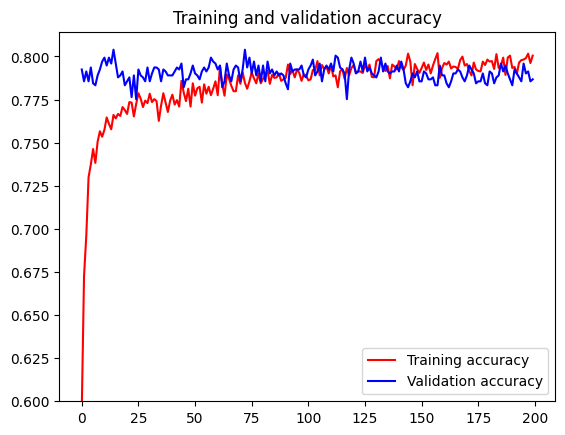

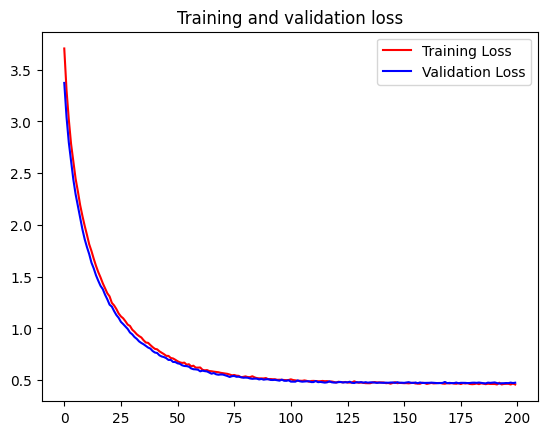

In [98]:
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim(0.6)
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [99]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4654
Test Accuracy: 0.8103


35/35 [==============================] - 0s 800us/step
              precision    recall  f1-score   support

           0       0.60      0.32      0.41       231
           1       0.84      0.94      0.89       860

    accuracy                           0.81      1091
   macro avg       0.72      0.63      0.65      1091
weighted avg       0.79      0.81      0.79      1091



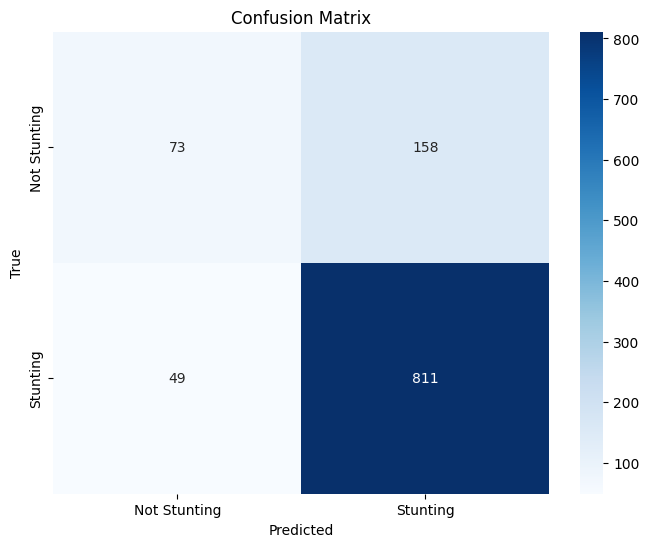

In [109]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
labels = ['Not Stunting', 'Stunting']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [111]:
model.save('./model/stunting_model.h5')
convert = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = convert.convert()

with open('./model/stunting_model.tflite', 'wb') as f:
    f.write(tflite)

INFO:tensorflow:Assets written to: C:\Users\KAZU\AppData\Local\Temp\tmp9t5d3j7b\assets


INFO:tensorflow:Assets written to: C:\Users\KAZU\AppData\Local\Temp\tmp9t5d3j7b\assets


# Hypertune

In [32]:
def build_model(hp):
        model = Sequential()
        model.add(
                layers.Dense(units=hp.Int("units_", min_value=64, max_value=128, step=32), activation="relu")
        )
        for i in range(1, hp.Int("num_layers", 2,5)):
                model.add(
                        layers.Dense(units=hp.Int("units_" + str(i), min_value=6, max_value=512, step=32), activation="relu")
                )
                
        model.add(
                layers.Dense(units=1, activation="sigmoid")
        )

        lr = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                      loss = tf.keras.losses.BinaryCrossentropy(),
                      metrics=["accuracy"]
                      )     
        
        return model

In [34]:
#DELETE HYPER TUNING FOLDER FIRST, default name untitled_project
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=80,
    factor=3,
    hyperband_iterations=10
)

In [35]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_ (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


In [36]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(X_train, y_train, 
             validation_data=(X_val, y_val), 
             epochs=100, 
             callbacks=[stop_early], 
             verbose=2)

Trial 220 Complete [00h 00m 02s]
val_accuracy: 0.8073394298553467

Best val_accuracy So Far: 0.8165137767791748
Total elapsed time: 00h 09m 34s

Search: Running Trial #221

Value             |Best Value So Far |Hyperparameter
64                |64                |units_
5                 |5                 |num_layers
230               |294               |units_1
0.01              |0.01              |learning_rate
422               |262               |units_2
166               |134               |units_3
358               |454               |units_4
9                 |80                |tuner/epochs
3                 |0                 |tuner/initial_epoch
3                 |0                 |tuner/bracket
1                 |0                 |tuner/round
0213              |None              |tuner/trial_id

Epoch 4/9
109/109 - 1s - loss: 0.4883 - accuracy: 0.7790 - val_loss: 0.4570 - val_accuracy: 0.8039 - 1s/epoch - 13ms/step
Epoch 5/9
109/109 - 0s - loss: 0.4859 - accuracy: 0.7844 

KeyboardInterrupt: 

In [397]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[stop_early], verbose=2)

Trial 100 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.8119266033172607
Total elapsed time: 00h 04m 09s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
4                 |2                 |num_layers
0.2               |0.2               |dropout_1
198               |262               |units_1
0.001             |0.01              |learning_rate
4                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0.1               |0.1               |dropout_2
6                 |358               |units_2
0.1               |0.3               |dropout_3
6                 |230               |units_3
0000              |None              |tuner/trial_id
0.5               |0.5               |dropout_4
294               |486               |units_4



Traceback (most recent call last):
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\tuners\hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "c:\Users\KAZU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_tuner\tuners\hyperband.py", line 432, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\KAZU\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\KAZU\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for .\untitled_project\trial_0000\checkpoint
